<a href="https://colab.research.google.com/github/475-Machine-Learning-Project/Machine-Learning-Final-Project/blob/main/main_64x64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import zipfile 
import gdown

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
# Root directory for dataset
dataroot = "data/places"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# weight betwee nvarious components of total generator loss
weightRecon = 0.99

# Number of training epochs
num_epochs = 300

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dataroot = "gdrive/MyDrive/ML Project/Dataset/PyTorch"

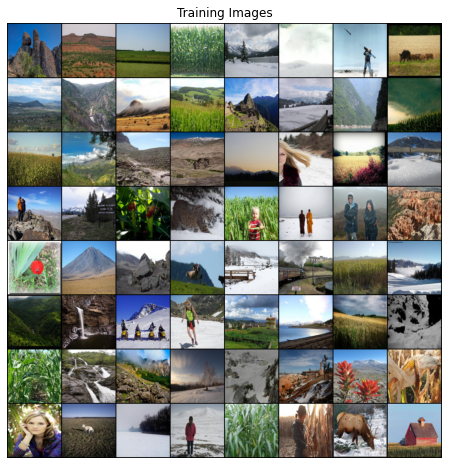

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Try other datasets below:

# dataset = dset.MNIST(root=dataroot, train=True, transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5), (0.5)),
#                            ]), download=True)
# nc = 1

# dataset = dset.Places365(root=dataroot, split='train-standard', small=True, transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]), download=True)


# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code -> generate a 64x64 mask from a 128x128 image

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            #128 images
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512,2048,kernel_size=(4,4)),#bottleneck

            # Decoder Part

            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(in_channels=2048,out_channels=512,kernel_size=(4,4),stride=1,padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # outputting 32x32 here

            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            #outputting 64x64 here

            # nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            # nn.BatchNorm2d(64),
            # nn.ReLU(),

            # outputting 128x128 here

            nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=(4,4),stride=2,padding=1, bias=False),
            nn.Tanh(),

        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
# Discrimnator for 64x64 mask
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            ## uncomment to import 128x128 masks
            # nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            # nn.BatchNorm2d(64),
            # nn.LeakyReLU(0.2,in_place=True),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=512,out_channels=1,kernel_size=(4,4), bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator\
# nz = 100
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
def get_block_mask(samples: torch.Tensor):
  image_size = samples.size()[-1]

  # clone images to be masked
  masked_samples = samples.clone()

  # Block out 32x32 centers
  masked_samples[:,0,32:96,32:96] = (2 * 117.0 / 255.0 - 1.0)
  masked_samples[:,1,32:96,32:96] = (2 * 104.0 / 255.0 - 1.0)
  masked_samples[:,2,32:96,32:96] = (2 * 123.0 / 255.0 - 1.0)

  true_masked_part = samples[:, :, 32:96, 32:96]

  return masked_samples, true_masked_part

In [ ]:
def get_weights(prediction_size: torch.Size):
    loss_weights = torch.ones(prediction_size)
    return loss_weights

def weighted_mse_loss(outputs, targets, weights):
    return torch.mean(weights * (outputs - targets).pow(2))


In [ ]:
# For training visualization purposes

viz_masked_samples, viz_true_masked_part = get_block_mask(real_batch[0].to(device))

In [ ]:
from re import L
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
G_mse_losses = []
G_Tot_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        masked_samples, true_masked_part = get_block_mask(real_cpu)

        # Forward pass real batch through D
        output = netD(true_masked_part).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        #noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with G
        fake = netG(masked_samples)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        # Add MSE lost between generated infil and origional
        l2_weights = get_weights(fake.size())
        lossGeneratorRecon = weighted_mse_loss(fake, true_masked_part, l2_weights.to(device))
        lossGeneratorTotal = (1 - weightRecon) * errG + weightRecon * lossGeneratorRecon

        lossGeneratorTotal.backward()
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            G_mse_losses.append(lossGeneratorRecon.item())
            G_Tot_losses.append(lossGeneratorTotal.item())
            D_losses.append(errD.item())


        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_masked_samples).detach().cpu()
                viz_infill = viz_masked_samples.clone()
                viz_infill[:,:,32:96,32:96] = fake
            img_list.append(vutils.make_grid(viz_infill[:64].cpu(), padding=2, normalize=True))

        iters += 1

In [ ]:

# Uncomment to save GAN Save GAN 
torch.save({"epoch": epoch,
                    "state_dict_G": netG.state_dict(),
                    "state_dict_D": netD.state_dict(),
                    "optimizer_G": optimizerG.state_dict(),
                    "optimizer_D": optimizerD.state_dict(),
                    "img_list": img_list,
                    "G_losses": G_losses,
                    "G_mse_losses": G_mse_losses,
                    "G_Tot_losses": G_Tot_losses,
                    "D_losses": D_losses
}, 'gdrive/MyDrive/ML Project/Models/INFILL_64_219_99per_LOSSES.pth')

In [39]:
# Uncomment to Load GAN
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load('gdrive/MyDrive/ML Project/Models/INFILL_64_20_90per_LOSSES.pth')['state_dict_G'])
netG.eval()
img_list = []
img_list = torch.load('gdrive/MyDrive/ML Project/Models/INFILL_64_10_LOSSES.pth')['img_list']
G_Tot_losses = torch.load('gdrive/MyDrive/ML Project/Models/INFILL_64_10_LOSSES.pth')['G_Tot_losses']
D_losses = torch.load('gdrive/MyDrive/ML Project/Models/INFILL_64_10_LOSSES.pth')['D_losses']

with torch.no_grad():
  fake = netG(viz_masked_samples).detach().cpu()
  viz_infill = viz_masked_samples.clone()
  viz_infill[:,:,32:96,32:96] = fake
  img_list.append(vutils.make_grid(viz_infill[:64].cpu(), padding=2, normalize=True))

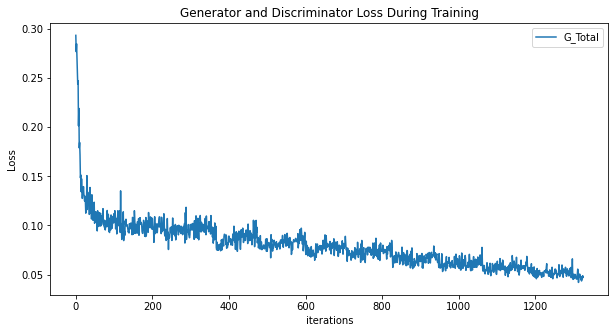

In [41]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
#plt.plot(G_losses,label="G")
#plt.plot(G_mse_losses,label="G_MSE")
plt.plot(G_Tot_losses,label="G_Total")
#plt.plot(D_losses,label="D_Total")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
#plt.rcParams['animation.embed_limit'] = 40
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

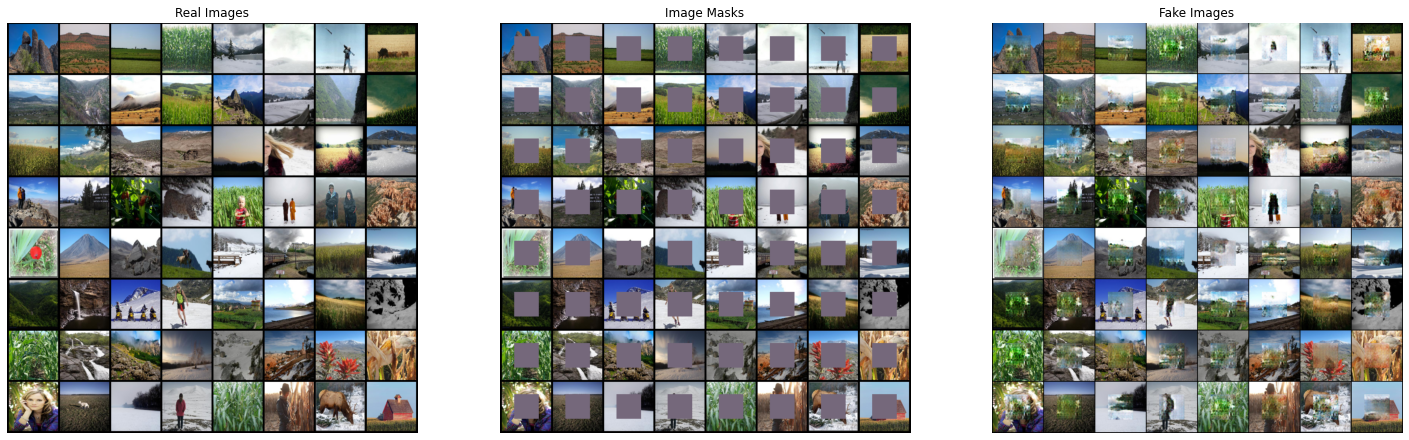

In [38]:
# Grab a batch of real images from the dataloader
#real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(25,25))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,3,2)
plt.axis("off")
plt.title("Image Masks")
plt.imshow(np.transpose(vutils.make_grid(viz_masked_samples.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,3,3)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Trial It Yourself!

In [23]:
# Upload an image -- will be resized to 128 x 128
from google.colab import files
import PIL
uploaded = files.upload()

Saving landscape-architecture-fun-facts-outside-productions-blog-980x551.jpg to landscape-architecture-fun-facts-outside-productions-blog-980x551 (1).jpg


In [24]:
uploaded.keys()

dict_keys(['landscape-architecture-fun-facts-outside-productions-blog-980x551.jpg'])

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])


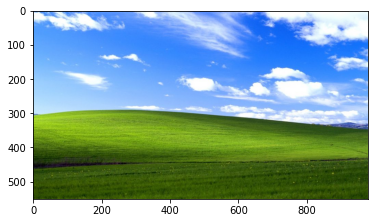

In [33]:
for key in uploaded.keys():
  im = PIL.Image.open(key)

#convert_tensor = transforms.ToTensor()
convert_tensor=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor()
                           ])


im_tensor = convert_tensor(im)
print(im_tensor.shape)
if im_tensor.shape[0] != 3:
  im_tensor = im_tensor[0:3,:,:]
im_tensor = im_tensor.unsqueeze(dim=0).to(device)
print(im_tensor.shape)
plt.imshow(im)
plt.show() 

In [34]:
test_masked_samples, test_true_masked_part = get_block_mask(im_tensor.to(device))
test_masked_samples.shape

torch.Size([1, 3, 128, 128])

In [35]:
netG.eval()
with torch.no_grad():
  fake = netG(test_masked_samples).detach().cpu()
  viz_infill = test_masked_samples.clone()
  viz_infill[:,:,32:96,32:96] = fake

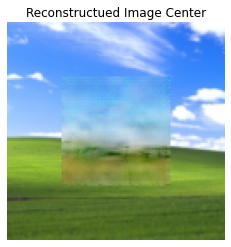

In [36]:

plt.figure()
plt.axis("off")
plt.title("Reconstructued Image Center")
plt.imshow(np.transpose(vutils.make_grid(viz_infill[-1].cpu(), padding=2, normalize=True),(1,2,0)))